# News Recommendation System



## Problem Statement

Build an appropriate recommendation system that would:

1. Recommend new top 10 relevant articles to a user when he visits the app at the start of the day

2. Recommend top 10 similar news articles that match the ones clicked by the user. Try different models for generating these recommendations and experiment with hybrid models for the same


You have to ensure that the system does not recommend any news article that has been pulled out from the app or has already been seen by the user. In addition, only the articles that are written in the English language must be considered for content-based recommendations. The final generated list must contain the names of the recommended articles, along with their IDs.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')  # To ignore warnings

In [2]:
consumer_transactions = pd.read_csv('consumer_transanctions.csv', low_memory=False)
platform_content = pd.read_csv('platform_content.csv')

In [3]:
consumer_transactions.head()

,event_timestamp,interaction_type,item_id,consumer_id,consumer_session_id,consumer_device_info,consumer_location,country
0,1465413032,content_watched,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,content_watched,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,content_watched,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,content_followed,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,content_watched,-7820640624231356730,-445337111692715325,561148 1178424124714,NaN,NaN,NaN


In [4]:
platform_content.head()

,event_timestamp,interaction_type,item_id,producer_id,producer_session_id,producer_device_info,producer_location,producer_country,item_type,item_url,title,text_description,language
0,1459192779,content_pulled_out,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,content_present,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,content_present,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,content_present,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,content_present,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en


## Exploratory Data Analysis

### Consumer Transactions Data

In [5]:
consumer_transactions.head()

,event_timestamp,interaction_type,item_id,consumer_id,consumer_session_id,consumer_device_info,consumer_location,country
0,1465413032,content_watched,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,content_watched,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,content_watched,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,content_followed,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,content_watched,-7820640624231356730,-445337111692715325,561148 1178424124714,NaN,NaN,NaN


In [6]:
consumer_transactions.shape

(72312, 8)

In [7]:
consumer_transactions.describe()

,event_timestamp,item_id,consumer_id
count,7.231200e+04,7.231200e+04,7.231200e+04
mean,1.470103e+09,-3.033423e+16,1.252026e+16
std,7.258130e+06,5.344755e+18,5.022333e+18
min,1.457964e+09,-9.222795e+18,-9.223122e+18
25%,1.464876e+09,-4.726309e+18,-3.596627e+18
50%,1.468343e+09,1.893099e+16,-1.088422e+17
75%,1.474461e+09,4.441012e+18,3.766319e+18
max,1.488310e+09,9.222265e+18,9.210531e+18


In [8]:
consumer_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72312 entries, 0 to 72311
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   event_timestamp       72312 non-null  int64 
 1   interaction_type      72312 non-null  object
 2   item_id               72312 non-null  int64 
 3   consumer_id           72312 non-null  int64 
 4   consumer_session_id   72312 non-null  object
 5   consumer_device_info  56918 non-null  object
 6   consumer_location     56907 non-null  object
 7   country               56918 non-null  object
dtypes: int64(3), object(5)
memory usage: 4.4+ MB


In [9]:
consumer_transactions['interaction_type'].value_counts()

content_watched         61086
content_liked            5745
content_saved            2463
content_commented_on     1611
content_followed         1407
Name: interaction_type, dtype: int64

Imputing the rating values based on the feature ‘interaction type’ with the highest weightage to content_followed, followed by content_commented_on, content saved, content liked and content_watched

In [10]:
consumer_transactions['ratings'] = consumer_transactions['interaction_type'].map({
    'content_followed': 5,
    'content_commented_on': 4,
    'content_saved': 3,
    'content_liked': 2,
    'content_watched': 1
})

In [11]:
# Check for missing values
print("Missing values in consumer_transactions:")
print(consumer_transactions.isnull().sum())

Missing values in consumer_transactions:
event_timestamp             0
interaction_type            0
item_id                     0
consumer_id                 0
consumer_session_id         0
consumer_device_info    15394
consumer_location       15405
country                 15394
ratings                     0
dtype: int64


In [12]:
# Temporal analysis - convert event_timestamp to datetime 
consumer_transactions['interaction_time'] = pd.to_datetime(consumer_transactions['event_timestamp'], unit='s')

# Extract time components for analysis
consumer_transactions['date'] = consumer_transactions['interaction_time'].dt.date
consumer_transactions['hour'] = consumer_transactions['interaction_time'].dt.hour
consumer_transactions['day_of_week'] = consumer_transactions['interaction_time'].dt.day_name()
consumer_transactions['month'] = consumer_transactions['interaction_time'].dt.month

print("Temporal analysis completed. New columns added: interaction_time, date, hour, day_of_week, month")
print(f"Date range: {consumer_transactions['interaction_time'].min()} to {consumer_transactions['interaction_time'].max()}")

Temporal analysis completed. New columns added: interaction_time, date, hour, day_of_week, month
Date range: 2016-03-14 13:54:36 to 2017-02-28 19:21:51


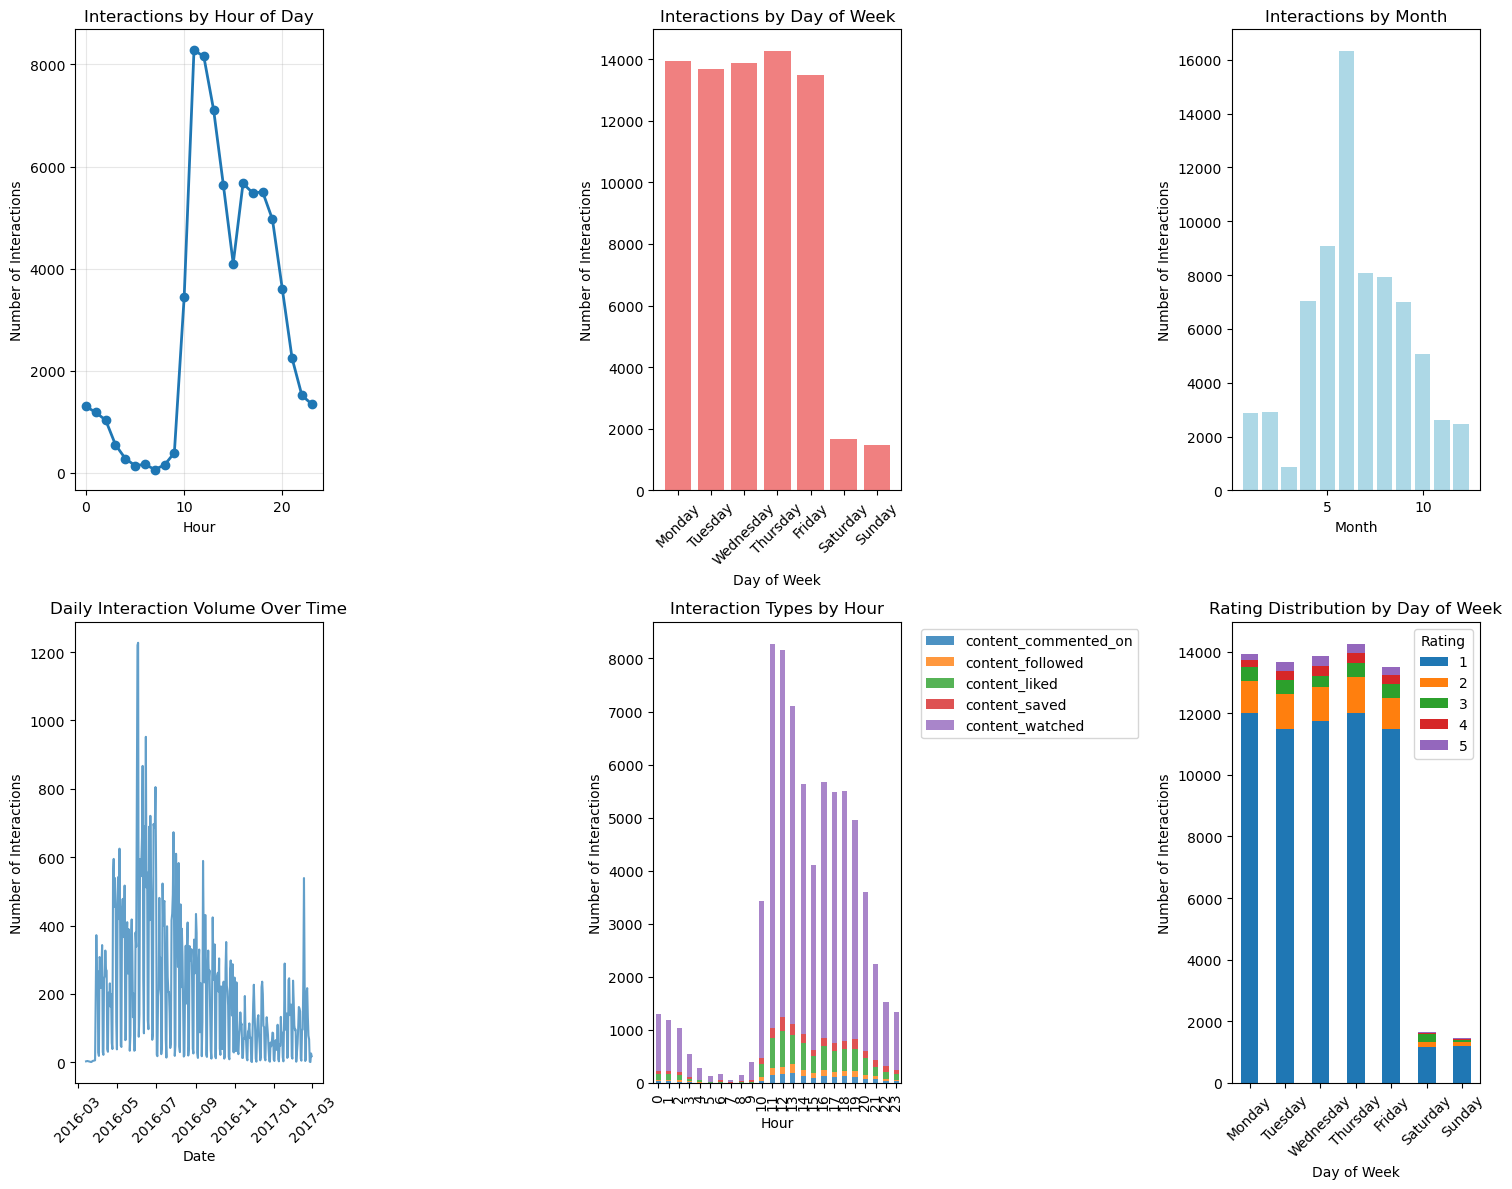

In [13]:
# Temporal patterns visualization
plt.figure(figsize=(15, 12))

# 1. Interactions by hour of day
plt.subplot(2, 3, 1)
hourly_interactions = consumer_transactions.groupby('hour').size()
plt.plot(hourly_interactions.index, hourly_interactions.values, marker='o', linewidth=2, markersize=6)
plt.title('Interactions by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Interactions')
plt.grid(True, alpha=0.3)

# 2. Interactions by day of week
plt.subplot(2, 3, 2)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_interactions = consumer_transactions.groupby('day_of_week').size().reindex(day_order)
plt.bar(daily_interactions.index, daily_interactions.values, color='lightcoral')
plt.title('Interactions by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Interactions')
plt.xticks(rotation=45)

# 3. Interactions by month
plt.subplot(2, 3, 3)
monthly_interactions = consumer_transactions.groupby('month').size()
plt.bar(monthly_interactions.index, monthly_interactions.values, color='lightblue')
plt.title('Interactions by Month')
plt.xlabel('Month')
plt.ylabel('Number of Interactions')

# 4. Daily interaction volume over time
plt.subplot(2, 3, 4)
daily_volume = consumer_transactions.groupby('date').size()
plt.plot(daily_volume.index, daily_volume.values, alpha=0.7)
plt.title('Daily Interaction Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Interactions')
plt.xticks(rotation=45)

# 5. Interaction type distribution by hour
plt.subplot(2, 3, 5)
interaction_hour_pivot = consumer_transactions.pivot_table(
    values='consumer_id', 
    index='hour', 
    columns='interaction_type', 
    aggfunc='count', 
    fill_value=0
)
interaction_hour_pivot.plot(kind='bar', stacked=True, ax=plt.gca(), alpha=0.8)
plt.title('Interaction Types by Hour')
plt.xlabel('Hour')
plt.ylabel('Number of Interactions')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 6. Rating distribution by day of week
plt.subplot(2, 3, 6)
rating_day_pivot = consumer_transactions.pivot_table(
    values='consumer_id', 
    index='day_of_week', 
    columns='ratings', 
    aggfunc='count', 
    fill_value=0
).reindex(day_order)
rating_day_pivot.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Rating Distribution by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Interactions')
plt.xticks(rotation=45)
plt.legend(title='Rating')

plt.tight_layout()
plt.show()

#### Inference for consumer_transactions data:

- Most of the consumers are from BR, followed by US
- Most of the interaction_types are content_watched, followed by content_liked, content_saved, content_commented_on and content_followed
- Top consumer_locations are SP, then followed by MG


### Platform content EDA

In [14]:
platform_content.head()

,event_timestamp,interaction_type,item_id,producer_id,producer_session_id,producer_device_info,producer_location,producer_country,item_type,item_url,title,text_description,language
0,1459192779,content_pulled_out,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,content_present,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,content_present,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,content_present,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,content_present,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en


In [15]:
print(platform_content['interaction_type'].value_counts())
print('--------------')
print(platform_content['producer_device_info'].value_counts())
print('--------------')
print(platform_content['item_type'].value_counts())
print('--------------')
print(platform_content['language'].value_counts())
print('--------------')
print(platform_content['producer_location'].value_counts())

content_present       3047
content_pulled_out      75
Name: interaction_type, dtype: int64
--------------
Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2785.116 Safari/537.36                   71
Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2883.87 Safari/537.36               65
Android - Native Mobile App                                                                                                 35
Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2883.87 Safari/537.36                    29
Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2785.143 Safari/537.36                   28
                                                                                                                            ..
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2883.75 Safari/537.36     1
Mozil

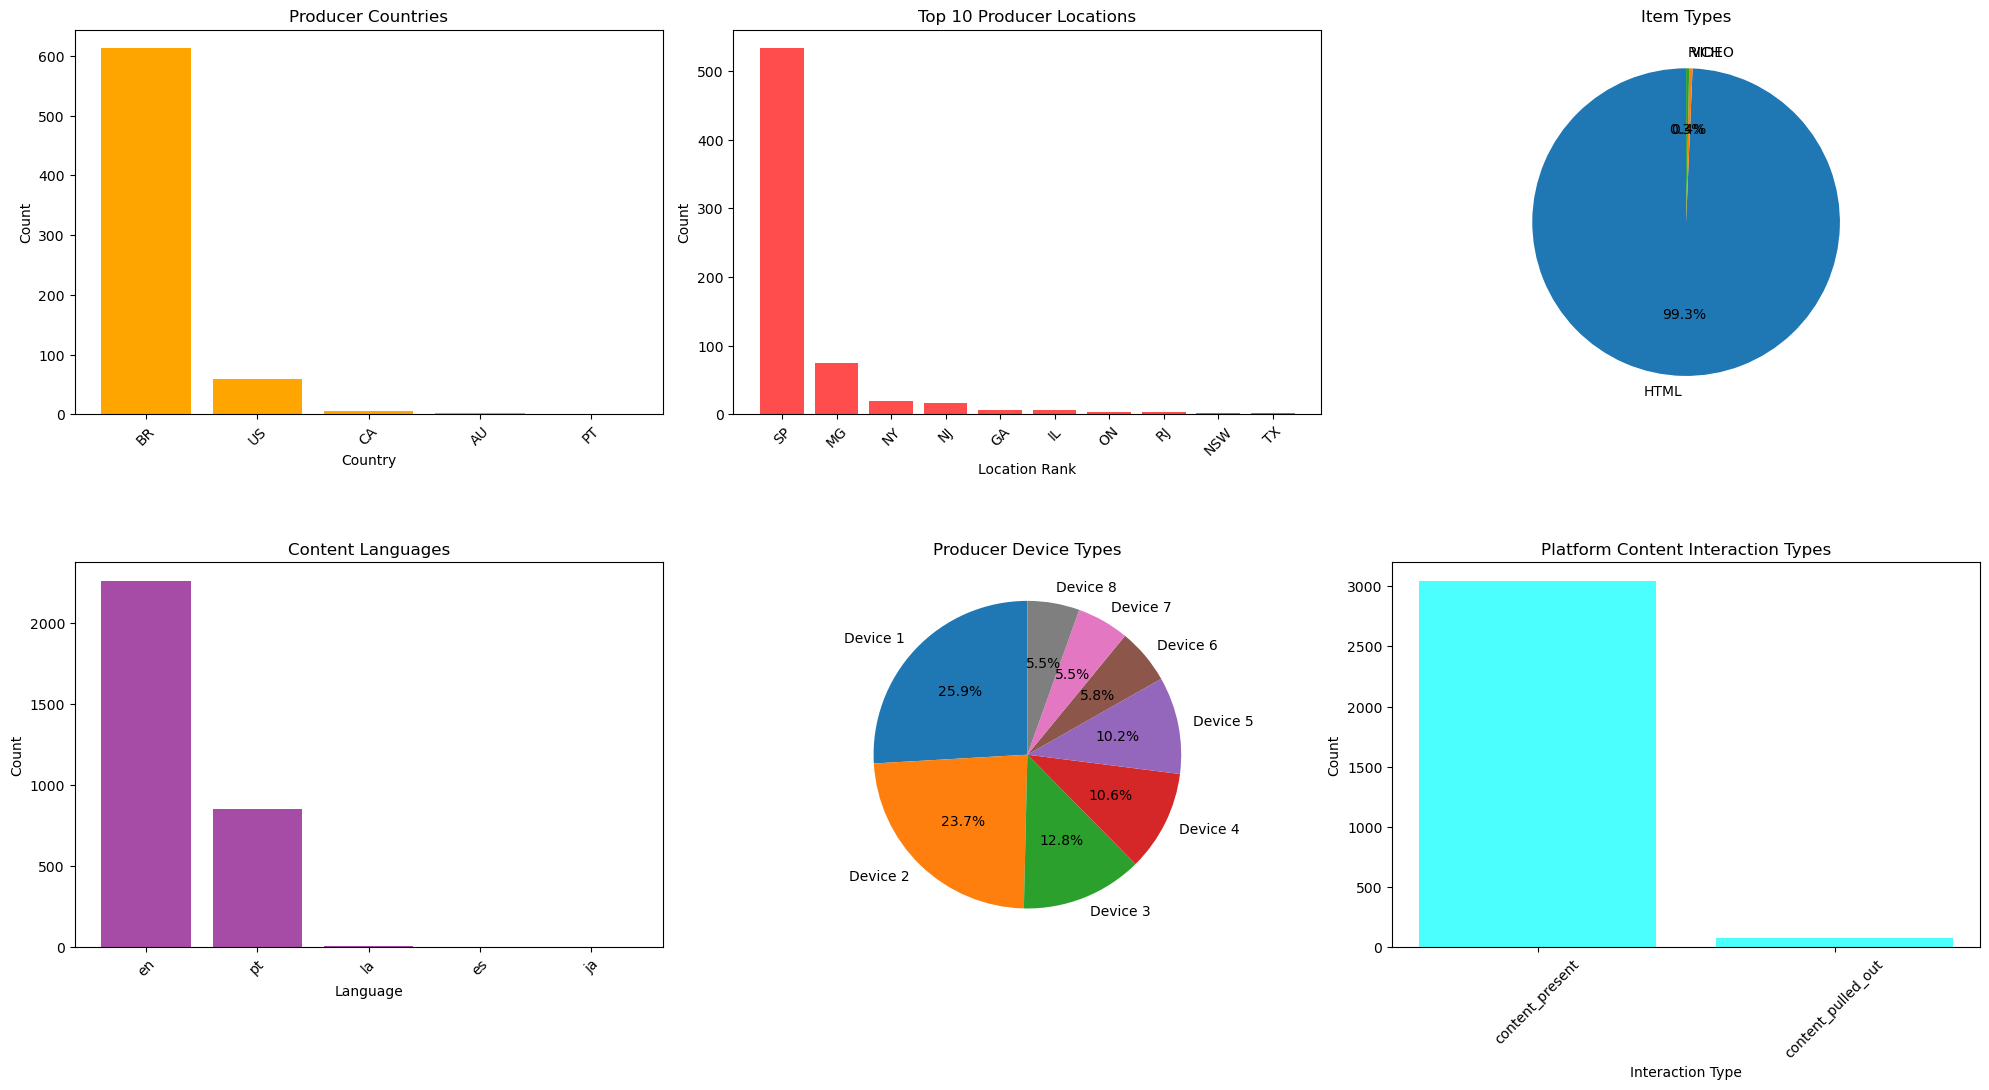

In [16]:
# Check the distribution of interaction type, producer location/country

plt.figure(figsize=(20, 15))

# 1. Producer Country Distribution (Platform Content)
plt.subplot(3, 3, 1)
producer_countries = platform_content['producer_country'].value_counts().head(10)
plt.bar(range(len(producer_countries)), producer_countries.values, color='orange')
plt.title('Producer Countries')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(range(len(producer_countries)), producer_countries.index, rotation=45)

# 2. Producer Location Distribution
plt.subplot(3, 3, 2)
producer_locations = platform_content['producer_location'].value_counts().head(10)
plt.bar(range(len(producer_locations)), producer_locations.values, color='red', alpha=0.7)
plt.title('Top 10 Producer Locations')
plt.xlabel('Location Rank')
plt.ylabel('Count')
plt.xticks(range(len(producer_locations)), producer_locations.index, rotation=45)

# 3. Item Type Distribution (Platform Content)
plt.subplot(3, 3, 3)
item_types = platform_content['item_type'].value_counts()
plt.pie(item_types.values, labels=item_types.index, autopct='%1.1f%%', startangle=90)
plt.title('Item Types')

# 4. Language Distribution (Platform Content)
plt.subplot(3, 3, 4)
languages = platform_content['language'].value_counts()
plt.bar(languages.index, languages.values, color='purple', alpha=0.7)
plt.title('Content Languages')
plt.xlabel('Language')
plt.ylabel('Count')
plt.xticks(rotation=45)

# 5. Producer Device Info Distribution
plt.subplot(3, 3, 5)
producer_devices = platform_content['producer_device_info'].value_counts().head(8)
plt.pie(producer_devices.values, labels=[f'Device {i+1}' for i in range(len(producer_devices))], autopct='%1.1f%%', startangle=90)
plt.title('Producer Device Types')

# 6. Interaction Type Distribution (Platform Content)
plt.subplot(3, 3, 6)
platform_interactions = platform_content['interaction_type'].value_counts()
plt.bar(platform_interactions.index, platform_interactions.values, color='cyan', alpha=0.7)
plt.title('Platform Content Interaction Types')
plt.xlabel('Interaction Type')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#### Inference for platform_content data:

- Most of the producers are from BR, followed by US
- content_present is very high compared to content_pulled_out
- Content languages are mostly in English and Portuguese
- Most contents are in HTML



### Data cleaning and preprocessing

We will only consider articles writien in English for content-based recommendations.

In [17]:
platform_content_en = platform_content[platform_content.language == 'en']
platform_content_en.shape

(2264, 13)

Removing articles that are pulled out from the platform content data.

In [18]:
platform_content_en = platform_content_en[platform_content_en.interaction_type == 'content_present']
platform_content_en.shape

(2211, 13)

In [19]:
platform_content_en.isna().sum() #check the null values for columns 

event_timestamp            0
interaction_type           0
item_id                    0
producer_id                0
producer_session_id        0
producer_device_info    1744
producer_location       1744
producer_country        1744
item_type                  0
item_url                   0
title                      0
text_description           0
language                   0
dtype: int64

Inference:

- None of the columns having null values impact the recommendation system

In [20]:
platform_content_en.head(2)

,event_timestamp,interaction_type,item_id,producer_id,producer_session_id,producer_device_info,producer_location,producer_country,item_type,item_url,title,text_description,language
1,1459193988,content_present,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,content_present,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en


## Content Based Filtering
Content-based filtering methods are based on a description of the item and a profile of the user’s preference. The objective is to recommend items similar to those that a user liked in the past. We will use TF-IDF Vectorizer to convert the text data into vectors and then use cosine similarity to find the similar articles.

In [21]:
platform_content_df = platform_content_en[['item_id', 'title', 'text_description']]
platform_content_df.head()

,item_id,title,text_description
1,-4110354420726924665,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...
2,-7292285110016212249,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...
3,-6151852268067518688,Google Data Center 360° Tour,We're excited to share the Google Data Center ...
4,2448026894306402386,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...
5,-2826566343807132236,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...


In [22]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('punkt_tab')  # Added this for the new NLTK version
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rishabhsaha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/rishabhsaha/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rishabhsaha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
# add stemming and lemmatisation in the preprocess function
def preprocess(document):
    'changes document to lower case and removes stopwords'

    if document is None or pd.isna(document):
        return []
    
    # change sentence to lower case
    document = document.lower()

    # tokenize into words
    words = word_tokenize(document)

    # remove stop words
    words = [word for word in words if word not in stopwords.words("english")]

    
    return words

In [24]:
# split the text description into keywords
platform_content_df['keywords'] = platform_content_df['text_description'].map(lambda x: preprocess(x))
# platform_content_df['keywords'] = platform_content_df['text_description'].map(lambda x: x.lower().split())

platform_content_df.head()

,item_id,title,text_description,keywords
1,-4110354420726924665,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,"[work, still, early, ., first, full, public, v..."
2,-7292285110016212249,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,"[alarm, clock, wakes, 8:00, stream, advert-fre..."
3,-6151852268067518688,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,"['re, excited, share, google, data, center, 36..."
4,2448026894306402386,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,"[aite, group, projects, blockchain, market, co..."
5,-2826566343807132236,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,"[one, largest, oldest, organizations, computin..."


In [25]:

words_list = platform_content_df['keywords'].tolist()
words_list[:2]  # Display the first two lists of keywords

[['work',
  'still',
  'early',
  '.',
  'first',
  'full',
  'public',
  'version',
  'ethereum',
  'software',
  'recently',
  'released',
  ',',
  'system',
  'could',
  'face',
  'technical',
  'legal',
  'problems',
  'tarnished',
  'bitcoin',
  '.',
  'many',
  'bitcoin',
  'advocates',
  'say',
  'ethereum',
  'face',
  'security',
  'problems',
  'bitcoin',
  'greater',
  'complexity',
  'software',
  '.',
  'thus',
  'far',
  ',',
  'ethereum',
  'faced',
  'much',
  'less',
  'testing',
  ',',
  'many',
  'fewer',
  'attacks',
  ',',
  'bitcoin',
  '.',
  'novel',
  'design',
  'ethereum',
  'may',
  'also',
  'invite',
  'intense',
  'scrutiny',
  'authorities',
  'given',
  'potentially',
  'fraudulent',
  'contracts',
  ',',
  'like',
  'ponzi',
  'schemes',
  ',',
  'written',
  'directly',
  'ethereum',
  'system',
  '.',
  'sophisticated',
  'capabilities',
  'system',
  'made',
  'fascinating',
  'executives',
  'corporate',
  'america',
  '.',
  'ibm',
  'said',
  'la

In [26]:
# Compatibility shim: ensure scipy.linalg.triu exists (some SciPy versions don't export it)
import scipy.linalg as scl
import numpy as np

if not hasattr(scl, "triu"):
    scl.triu = np.triu

In [27]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.similarities import MatrixSimilarity
import numpy as np  # Use numpy for triu if needed

words_list = platform_content_df['keywords'].tolist()

# create a dictionary from words list
dictionary = Dictionary(words_list) 

#create corpus where the corpus is a bag of words for each document
corpus = [dictionary.doc2bow(doc) for doc in words_list] 

#create tfidf model of the corpus
tfidf = TfidfModel(corpus) 

# Create the similarity matrix. This is the most important part where we get the similarities between the movies.
sims = MatrixSimilarity(tfidf[corpus], num_features=len(dictionary))


In [28]:
def recommend_news(news_title, no_of_recommendations):
    'This function takes news title and number of recommendations as input and returns recommended news titles'

    article = platform_content_df[platform_content_df.title == news_title]
    
    if article.empty:
        return "News title not found in the dataset."
    
    #get the index of the news title
    news_index = article.index[0]
    # print('news title:', news_title)
    # print('news text_description:', platform_content_df.iloc[news_index]['text_description'])

    
    #get the keywords of the news title
    news_keywords = platform_content_df.iloc[news_index]['keywords']
    # print('news keywords:', news_keywords)

    #convert the keywords to bag of words
    news_bow = dictionary.doc2bow(news_keywords)

    #get the tfidf vector of the news title
    news_tfidf = tfidf[news_bow]

    #get the similarity scores of the news title with all other news titles
    similarity_scores = sims[news_tfidf]

    #sort the similarity scores in descending order
    sorted_similar_news = np.argsort(similarity_scores)[::-1]

    #get the top n similar news titles
    recommended_news_indices = sorted_similar_news[1:no_of_recommendations+1]

    # create a pd.DataFrame to store recommended news titles, index and similarity score
    recommended_news_titles = platform_content_df.iloc[recommended_news_indices]['title'].tolist()
    recommended_news_scores = similarity_scores[recommended_news_indices].tolist()
    content_score_normalized = (recommended_news_scores - np.min(recommended_news_scores)) / (np.max(recommended_news_scores) - np.min(recommended_news_scores))
    
    recommended_news_df = pd.DataFrame({
        'title': recommended_news_titles,
        'similarity_score': recommended_news_scores,
        'content_score_normalized': content_score_normalized
    })

    return recommended_news_df

In [29]:
# get 1st title from platform_content_df
sample_news_title = platform_content_df.iloc[2]['title']
print(sample_news_title)

Google Data Center 360° Tour


In [30]:
news_title = sample_news_title
no_of_recommendations = 10


In [31]:
recommended_news = recommend_news(news_title, no_of_recommendations)

recommended_news

,title,similarity_score,content_score_normalized
0,Are you a bitcoin denialist? - Chris Skinner's...,0.304945,1.000000
1,Blockchain won't kill banks: Bitcoin pioneer,0.252177,0.409362
2,Venture Capitalists Inject Nearly Half a Billi...,0.251886,0.406107
3,IBM Watson is Working to Bring AI to the Block...,0.232585,0.190068
4,The Blockchain is the new Google,0.227057,0.128189
5,"Our Goal is to Replace Your Need for a Bank, S...",0.218589,0.033412
6,Stratumn is building a sort of Heroku for bloc...,0.217994,0.026746
7,Banks find blockchain hard to put into practic...,0.217975,0.026534
8,Red Hat OpenShift Blockchain Initiative Focuse...,0.216593,0.011067
9,Ethereum and Bitcoin Are Market Leaders But No...,0.215604,0.000000


## Collaborative Filtering: User Based Recommendations
- Create user-item matrix using the rating values.
- Find the user-similarity matrix based on a similarity measure.
- Generate predicted ratings for all the user-item pairs.

In [32]:
consumer_transactions.head()

,event_timestamp,interaction_type,item_id,consumer_id,consumer_session_id,consumer_device_info,consumer_location,country,ratings,interaction_time,date,hour,day_of_week,month
0,1465413032,content_watched,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN,1,2016-06-08 19:10:32,2016-06-08,19,Wednesday,6
1,1465412560,content_watched,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US,1,2016-06-08 19:02:40,2016-06-08,19,Wednesday,6
2,1465416190,content_watched,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN,1,2016-06-08 20:03:10,2016-06-08,20,Wednesday,6
3,1465413895,content_followed,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN,5,2016-06-08 19:24:55,2016-06-08,19,Wednesday,6
4,1465412290,content_watched,-7820640624231356730,-445337111692715325,561148 1178424124714,NaN,NaN,NaN,1,2016-06-08 18:58:10,2016-06-08,18,Wednesday,6


In [33]:
platform_content_df.head()

,item_id,title,text_description,keywords
1,-4110354420726924665,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,"[work, still, early, ., first, full, public, v..."
2,-7292285110016212249,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,"[alarm, clock, wakes, 8:00, stream, advert-fre..."
3,-6151852268067518688,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,"['re, excited, share, google, data, center, 36..."
4,2448026894306402386,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,"[aite, group, projects, blockchain, market, co..."
5,-2826566343807132236,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,"[one, largest, oldest, organizations, computin..."


Selecting only necessary columns from consumer_transactions data for building the user-item matrix
- item_id
- consumer_id
- ratings

In [34]:
consumers_df = consumer_transactions[['consumer_id', 'item_id', 'ratings']]
consumers_df.head()

,consumer_id,item_id,ratings
0,-8845298781299428018,-3499919498720038879,1
1,-1032019229384696495,8890720798209849691,1
2,-1130272294246983140,310515487419366995,1
3,344280948527967603,310515487419366995,5
4,-445337111692715325,-7820640624231356730,1


In [35]:
n_consumers = consumers_df['consumer_id'].nunique()

n_articles = consumers_df['item_id'].nunique()

print("Number of unique consumers:", n_consumers)
print("Number of unique articles:", n_articles)

Number of unique consumers: 1895
Number of unique articles: 2987


We will need index in continuous order rather than numbers like -8845298781299428018	

In [36]:
print("consumers_df sample before factorize:")
print(consumers_df[['consumer_id','item_id']].head())

consumers_df sample before factorize:
           consumer_id              item_id
0 -8845298781299428018 -3499919498720038879
1 -1032019229384696495  8890720798209849691
2 -1130272294246983140   310515487419366995
3   344280948527967603   310515487419366995
4  -445337111692715325 -7820640624231356730


In [37]:
# Replace consumer_id and item_id with unique continuous numbers
consumers_df_copy = consumers_df.copy()

consumer_codes, user_uniques = pd.factorize(consumers_df['consumer_id'])
consumers_df_copy['consumer_id'] = consumer_codes

item_codes, item_uniques = pd.factorize(consumers_df['item_id'])
consumers_df_copy['item_id'] = item_codes

consumers_df_copy.head(10)

,consumer_id,item_id,ratings
0,0,0,1
1,1,1,1
2,2,2,1
3,3,2,5
4,4,3,1
5,5,2,1
6,6,4,1
7,7,5,1
8,3,2,1
9,6,6,1


In [38]:
# create mapping dicts (0-based -> original) and reverse maps (original -> 0-based)
user_id_map = {i: orig for i, orig in enumerate(user_uniques)}
item_id_map = {i: orig for i, orig in enumerate(item_uniques)}
user_id_reverse_map = {orig: i for i, orig in enumerate(user_uniques)}
item_id_reverse_map = {orig: i for i, orig in enumerate(item_uniques)}

In [39]:
user_id_map, item_id_map

({0: -8845298781299428018,
  1: -1032019229384696495,
  2: -1130272294246983140,
  3: 344280948527967603,
  4: -445337111692715325,
  5: -8763398617720485024,
  6: 3609194402293569455,
  7: 4254153380739593270,
  8: 1908339160857512799,
  9: 7781822014935525018,
  10: 8239286975497580612,
  11: 2766187446275090740,
  12: -1479311724257856983,
  13: -108842214936804958,
  14: 7022645187549453002,
  15: 6879394870211872116,
  16: -1387464358334758758,
  17: -8424644554119645763,
  18: -1602833675167376798,
  19: 5621833459783231486,
  20: -2626634673110551643,
  21: -6153009241569363021,
  22: -4585796377251906117,
  23: -2339455719722814827,
  24: 4340306774493623681,
  25: 5683029675627635125,
  26: -1443636648652872475,
  27: 3891637997717104548,
  28: -2050699458865052139,
  29: 3429602690322213789,
  30: -2772844562500836582,
  31: 22763587941636338,
  32: -7990997793599977496,
  33: 3094513233385472738,
  34: -6998647087289883231,
  35: 8766802480854827422,
  36: 540447082434826276

In [40]:
user_id_reverse_map, item_id_reverse_map

({-8845298781299428018: 0,
  -1032019229384696495: 1,
  -1130272294246983140: 2,
  344280948527967603: 3,
  -445337111692715325: 4,
  -8763398617720485024: 5,
  3609194402293569455: 6,
  4254153380739593270: 7,
  1908339160857512799: 8,
  7781822014935525018: 9,
  8239286975497580612: 10,
  2766187446275090740: 11,
  -1479311724257856983: 12,
  -108842214936804958: 13,
  7022645187549453002: 14,
  6879394870211872116: 15,
  -1387464358334758758: 16,
  -8424644554119645763: 17,
  -1602833675167376798: 18,
  5621833459783231486: 19,
  -2626634673110551643: 20,
  -6153009241569363021: 21,
  -4585796377251906117: 22,
  -2339455719722814827: 23,
  4340306774493623681: 24,
  5683029675627635125: 25,
  -1443636648652872475: 26,
  3891637997717104548: 27,
  -2050699458865052139: 28,
  3429602690322213789: 29,
  -2772844562500836582: 30,
  22763587941636338: 31,
  -7990997793599977496: 32,
  3094513233385472738: 33,
  -6998647087289883231: 34,
  8766802480854827422: 35,
  5404470824348262768: 3

In [41]:
n_consumers = consumers_df_copy['consumer_id'].nunique()

n_articles = consumers_df_copy['item_id'].nunique()

print("Number of unique consumers:", n_consumers)
print("Number of unique articles:", n_articles)

Number of unique consumers: 1895
Number of unique articles: 2987


#### Dividing the data into train and test sets

In [42]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(consumers_df_copy, test_size=0.3, random_state=32)

In [43]:
print(train_data.shape)
print(test_data.shape)
print(consumers_df_copy.shape)

(50618, 3)
(21694, 3)
(72312, 3)


In [44]:
train_data['ratings'].value_counts()

1    42793
2     4023
3     1732
4     1098
5      972
Name: ratings, dtype: int64

#### Create empty data matrix: consumer-content matrix

In [45]:
# Create a zero matrix of shape (n_consumers, n_articles)
data_matrix = np.zeros((n_consumers, n_articles)) 
data_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [46]:
data_matrix.shape

(1895, 2987)

In [47]:
# Fill the data matrix with ratings from the training data
for row in train_data.itertuples():
    if ((row.consumer_id > 1895) or (row.item_id > 2987)):
        continue #move on to next line if the consumer id is > 1895 and item id>2987
    data_matrix[row.consumer_id, row.item_id] = row.ratings

In [48]:
print(data_matrix)

[[1. 2. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [49]:
print("Data matrix shape:", data_matrix.shape)

Data matrix shape: (1895, 2987)


#### News pairwise similarity distance

In [50]:
from sklearn.metrics.pairwise import pairwise_distances 

In [51]:
user_similarity = 1 - pairwise_distances(data_matrix, metric='cosine')
user_similarity

array([[1.        , 0.20522764, 0.07122536, ..., 0.        , 0.        ,
        0.        ],
       [0.20522764, 1.        , 0.07745657, ..., 0.        , 0.        ,
        0.        ],
       [0.07122536, 0.07745657, 1.        , ..., 0.        , 0.02635231,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.02635231, ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [52]:
data_matrix.T

array([[1., 0., 0., ..., 0., 0., 0.],
       [2., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [53]:
item_similarity = 1 - pairwise_distances(data_matrix.T, metric='cosine')
item_similarity

array([[1.        , 0.40522045, 0.09100315, ..., 0.        , 0.        ,
        0.        ],
       [0.40522045, 1.        , 0.07744031, ..., 0.        , 0.        ,
        0.        ],
       [0.09100315, 0.07744031, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [54]:
item_prediction = np.dot(user_similarity, data_matrix)

In [55]:
item_prediction.shape

(1895, 2987)

In [56]:
prediction_df = pd.DataFrame(item_prediction)
prediction_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2977,2978,2979,2980,2981,2982,2983,2984,2985,2986
0,1.989986,5.936508,1.529664,0.879107,0.192166,0.855695,1.131902,0.388321,0.228748,1.380273,...,0.006411,0.028773,0.067730,0.000000,0.000000,0.006452,0.022446,0.010252,0.0,0.0
1,1.379182,7.372846,3.965823,3.442824,0.433788,1.702230,2.015937,0.570472,0.355794,3.102962,...,0.007843,0.132581,0.212676,0.042251,0.005331,0.056568,0.006102,0.034842,0.0,0.0
2,0.419442,4.678887,3.539575,0.396203,0.274748,0.688787,0.748339,1.657814,0.407216,1.607478,...,0.000000,0.063119,0.115469,0.033672,0.000000,0.033025,0.021884,0.079968,0.0,0.0
3,0.036662,0.690253,5.015951,0.137211,0.018863,0.455441,0.072353,0.025126,0.241174,0.698563,...,0.000000,0.000000,0.018863,0.152286,0.000000,0.017070,0.079181,0.000000,0.0,0.0
4,0.490200,2.831764,2.469876,1.569931,0.279554,0.858919,0.751149,0.187986,0.301251,4.034381,...,0.018373,0.141180,0.094500,0.016496,0.018732,0.050848,0.010721,0.024485,0.0,0.0


Get recommended news articles for ConsumerId: 344280948527967603

In [57]:
# Predictions for a specific consumer
consumer_id = 344280948527967603

In [58]:
prediction_df.iloc[user_id_reverse_map[consumer_id] - 1]

0       0.419442
1       4.678887
2       3.539575
3       0.396203
4       0.274748
          ...   
2982    0.033025
2983    0.021884
2984    0.079968
2985    0.000000
2986    0.000000
Name: 2, Length: 2987, dtype: float64

In [59]:
prediction_df.iloc[user_id_reverse_map[consumer_id]].sort_values(ascending=False)[:10]

2899    15.236043
89       7.386231
2        5.015951
2931     3.765701
1821     3.158759
1531     3.121825
1602     2.908398
287      2.824455
202      2.805078
1470     2.394872
Name: 3, dtype: float64

In [60]:
recommendations_df = pd.DataFrame(prediction_df.iloc[user_id_reverse_map[consumer_id]].sort_values(ascending=False)[:10])
recommendations_df.head()

,3
2899,15.236043
89,7.386231
2,5.015951
2931,3.765701
1821,3.158759


In [61]:
recommendations_df.reset_index(inplace=True)

In [62]:
recommendations_df.head()

,index,3
0,2899,15.236043
1,89,7.386231
2,2,5.015951
3,2931,3.765701
4,1821,3.158759


In [63]:
recommendations_df.columns = ['item_id', 'predicted_rating']
recommendations_df.head(10)

,item_id,predicted_rating
0,2899,15.236043
1,89,7.386231
2,2,5.015951
3,2931,3.765701
4,1821,3.158759
5,1531,3.121825
6,1602,2.908398
7,287,2.824455
8,202,2.805078
9,1470,2.394872


In [64]:
item_id_map[89]

-5784991738549272379

In [65]:
# get the item_id from reverse item_id_map
recommendations_df['item_id'] = recommendations_df['item_id'].map(item_id_map)
recommendations_df.head(10)

,item_id,predicted_rating
0,4876769046116846438,15.236043
1,-5784991738549272379,7.386231
2,310515487419366995,5.015951
3,-4029704725707465084,3.765701
4,-908052164352446106,3.158759
5,-1297580205670251233,3.121825
6,-6783772548752091658,2.908398
7,3569727790804487273,2.824455
8,-6843047699859121724,2.805078
9,-133139342397538859,2.394872


#### Merge with platform_content data to get article names

In [66]:
merged_df = recommendations_df.merge(platform_content_df, on='item_id', how='left')
merged_df.head(10)

,item_id,predicted_rating,title,text_description,keywords
0,4876769046116846438,15.236043,NaN,NaN,NaN
1,-5784991738549272379,7.386231,NaN,NaN,NaN
2,310515487419366995,5.015951,NaN,NaN,NaN
3,-4029704725707465084,3.765701,Former Google career coach shares a visual tri...,"If you want 2017 to be an exciting year, desig...","[want, 2017, exciting, year, ,, design, way, ...."
4,-908052164352446106,3.158759,NaN,NaN,NaN
5,-1297580205670251233,3.121825,NaN,NaN,NaN
6,-6783772548752091658,2.908398,NaN,NaN,NaN
7,3569727790804487273,2.824455,DualShock 4 Repair,These are some common tools used to work on th...,"[common, tools, used, work, device, ., might, ..."
8,-6843047699859121724,2.805078,NaN,NaN,NaN
9,-133139342397538859,2.394872,NaN,NaN,NaN


#### Running Model Evaluation on Test Data

In [67]:
data_matrix_test = np.zeros((n_consumers, n_articles)) #create a zero matrix of shape (n_consumers, n_articles)
data_matrix_test.shape

(1895, 2987)

In [68]:
# Fill the data matrix with ratings from the test data
for row in test_data.itertuples():
    if ((row.consumer_id > 1895) or (row.item_id > 2987)):
        continue #move on to next line if the consumer id is > 1895 and item id>2987
    data_matrix_test[row.consumer_id, row.item_id] = row.ratings

In [69]:
data_matrix_test.shape

(1895, 2987)

In [70]:
# Import model evaluation packages
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt


In [71]:
def mae(prediction, ground_truth):

    prediction = prediction[ground_truth.nonzero()]
    
    ground_truth = ground_truth[ground_truth.nonzero()]
    
    return mean_absolute_error(prediction, ground_truth)

In [72]:

print(mae(item_prediction,data_matrix_test))


2.3313813199150983


mae of 2.33 is obtained on test data, which is slightly lower than the mae of 3.24 obtained on training data. This shows that the model is not overfitting and is performing well on unseen data.

RMSE

In [73]:
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()]
    ground_truth = ground_truth[ground_truth.nonzero()]
    return sqrt(mean_squared_error(prediction, ground_truth))

In [74]:
rmse(item_prediction,data_matrix_test)

4.332706183948997

Running on whole data for final model

In [75]:
data_matrix_full = np.zeros((n_consumers, n_articles)) #create a zero matrix of shape (n_consumers, n_articles) - user-item matrix
for row in consumers_df_copy.itertuples():
    data_matrix_full[row.consumer_id, row.item_id] = row.ratings

user_similarity = 1 - pairwise_distances(data_matrix_full, metric='cosine')
item_similarity = 1 - pairwise_distances(data_matrix_full.T, metric='cosine')
item_prediction = np.dot(user_similarity, data_matrix_full)
prediction_df = pd.DataFrame(item_prediction)
print("Final model MAE on full data:", mae(item_prediction, data_matrix_full))
print("Final model RMSE on full data:", rmse(item_prediction, data_matrix_full))

Final model MAE on full data: 4.038992847469755
Final model RMSE on full data: 6.844743992258645


In [76]:
def user_collaborative_filtering_top_n(consumer_id, n=10):
    'User Collaborative Filtering Model'
    recommendations_df = pd.DataFrame(prediction_df.iloc[user_id_reverse_map[consumer_id]].sort_values(ascending=False)[:10])
    recommendations_df.reset_index(inplace=True)
    recommendations_df.columns = ['item_id', 'predicted_rating']
    recommendations_df['item_id'] = recommendations_df['item_id'].map(item_id_map)
    merged_df = recommendations_df.merge(platform_content_df, on='item_id', how='left')
    return merged_df.head(n)


In [77]:
user_collaborative_filtering_top_n(1874422396201148365, n=10)

,item_id,predicted_rating,title,text_description,keywords
0,-2358756719610361882,21.886192,NaN,NaN,NaN
1,1738052593226421681,14.228828,NaN,NaN,NaN
2,6031953227014493100,9.798388,NaN,NaN,NaN
3,-4029704725707465084,8.658214,Former Google career coach shares a visual tri...,"If you want 2017 to be an exciting year, desig...","[want, 2017, exciting, year, ,, design, way, ...."
4,-6783772548752091658,7.159557,NaN,NaN,NaN
5,-8992803137960175254,6.977196,4 Reasons Managers Should Spend More Time on C...,There are managers who coach and managers who ...,"[managers, coach, managers, n't, ., leaders, l..."
6,8901449108040307914,6.933160,NaN,NaN,NaN
7,8224860111193157980,6.706149,NaN,NaN,NaN
8,-133139342397538859,5.882856,NaN,NaN,NaN
9,-8208801367848627943,5.823033,Ray Kurzweil: The world isn't getting worse - ...,"Ray Kurzweil, the author, inventor, computer s...","[ray, kurzweil, ,, author, ,, inventor, ,, com..."


## Collaborative Filtering: Item Based Recommendations
- Find the item-similarity matrix based on a similarity measure.
- Generate the top 10 similar and relevant items based on the similarity scores.

In [ ]:
data_matrix_full = np.zeros((n_consumers, n_articles)) #create a zero matrix of shape (n_consumers, n_articles) - user-item matrix
for row in consumers_df_copy.itertuples():
    data_matrix_full[row.consumer_id - 1, row.item_id - 1] = row.ratings

item_similarity = 1 - pairwise_distances(data_matrix_full.T, metric='cosine')
prediction_df = pd.DataFrame(item_similarity)

In [ ]:
def item_collaborative_filtering_top_n(item_id, n=10):
    'Item Collaborative Filtering Model'
    # get top-N predicted item indices for the given item
    recommendations_df = pd.DataFrame(
        prediction_df.iloc[item_id_reverse_map[item_id] - 1].sort_values(ascending=False)
    )
    recommendations_df.reset_index(inplace=True)
    recommendations_df.columns = ['item_id', 'predicted_rating']
    # map back to original item ids
    recommendations_df['item_id'] = recommendations_df['item_id'].map(item_id_map)
    # merge with content metadata
    merged_df = recommendations_df.merge(platform_content_df, on='item_id', how='left')
    # remove duplicate item rows (keep first)
    merged_df = merged_df.drop_duplicates(subset=['item_id'], keep='first')
    # keep only rows that have a title and copy to avoid SettingWithCopyWarning
    item_fil_df = merged_df[merged_df['title'].notna()].copy()
    # normalize predicted_rating into item_score_normalized safely
    pr = item_fil_df['predicted_rating']
    if pr.empty:
        item_fil_df['item_score_normalized'] = []
    else:
        if pr.max() == pr.min():
            item_fil_df['item_score_normalized'] = 0.0
        else:
            item_fil_df['item_score_normalized'] = (pr - pr.min()) / (pr.max() - pr.min())
    return item_fil_df.head(n)
# ...existing code...

In [80]:
item_id = 7905485530310717815

# print item from platform_content
print(platform_content[platform_content['item_id'] == item_id].title)

19    Blockchain Smart Contracts Startup Selected By...
Name: title, dtype: object


In [81]:
item_collaborative_filtering_top_n(item_id, n=10)

,item_id,predicted_rating,title,text_description,keywords,item_score_normalized
0,-4761420664091904483,1.000000,Now playing: New ISO security and privacy cert...,"Today, Google reiterated its commitment to the...","[today, ,, google, reiterated, commitment, sec...",1.00000
1,-4917007328809735647,0.857493,"Google Failure, Ethereum Leaps, ECB Giveout in...",This Friday the media discuss Google's prank f...,"[friday, media, discuss, google, 's, prank, fa...",0.51345
3,8084284001249507595,0.707107,Microsoft Continues to Embrace Ethereum & Bitc...,Microsoft Also read: Putin's Advisor: Bitcoin ...,"[microsoft, also, read, :, putin, 's, advisor,...",0.00000
4,-4265002939801511319,0.707107,Me an' Algernon,I'm afraid of publishing this for two reasons:...,"['m, afraid, publishing, two, reasons, :, ever...",0.00000
5,2106559900295325351,0.707107,"Applying the Linus Torvalds ""Good Taste"" Codin...","To the best of my ability to discern, the crux...","[best, ability, discern, ,, crux, ``, good, ta...",0.00000
7,-7586203274767893481,0.707107,Top 5 GCP NEXT breakout sessions on YouTube (s...,Couldn't make it to GCP NEXT last month? Lucky...,"[could, n't, make, gcp, next, last, month, ?, ...",0.00000
9,-4882849408937990337,0.707107,Dogville (2003),"20 wins & 25 nominations. See more awards "" St...","[20, wins, &, 25, nominations, ., see, awards,...",0.00000


## ALS Model
- Create Compressed Sparse user-item and item-user matrices. 
- Train the ALS model and generate recommendations for a user. Try experimenting with the hyperparameters.

In [82]:
consumer_als_df = consumers_df_copy.copy()
consumer_als_df

,consumer_id,item_id,ratings
0,0,0,1
1,1,1,1
2,2,2,1
3,3,2,5
4,4,3,1
...,...,...,...
72307,52,2825,2
72308,788,2821,1
72309,1670,2823,1
72310,52,2825,1


In [83]:
from scipy.sparse import csr_matrix
alpha = 40
# Create sparse consumer-item matrix
sparse_consumer_item = csr_matrix(( 
                                [alpha]*consumer_als_df.shape[0],
                                (consumer_als_df['consumer_id'], consumer_als_df['item_id']) )
                            )
sparse_consumer_item

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 40710 stored elements and shape (1895, 2987)>

In [84]:
# Quick sanity checks
assert sparse_consumer_item.shape[0] == len(consumer_als_df['consumer_id'].unique())
assert sparse_consumer_item.shape[1] == len(consumer_als_df['item_id'].unique())

In [85]:
sparse_consumer_item_array = sparse_consumer_item.toarray()
sparse_consumer_item_array

array([[ 80,  80,   0, ...,   0,   0,   0],
       [  0, 400, 480, ...,   0,   0,   0],
       [  0, 120, 400, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]])

In [86]:
len(sparse_consumer_item_array), len(sparse_consumer_item_array[0]), sparse_consumer_item_array[1][1]

(1895, 2987, 400)

In [87]:
max(sparse_consumer_item_array[1])

1160

In [88]:
print(sparse_consumer_item)

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 40710 stored elements and shape (1895, 2987)>
  Coords	Values
  (0, 0)	80
  (0, 1)	80
  (0, 7)	40
  (0, 27)	160
  (0, 37)	40
  (0, 41)	120
  (0, 51)	40
  (0, 53)	40
  (0, 67)	280
  (0, 86)	40
  (0, 88)	80
  (0, 93)	40
  (0, 103)	40
  (0, 163)	80
  (0, 168)	80
  (0, 171)	40
  (0, 183)	80
  (0, 217)	40
  (0, 220)	280
  (0, 238)	40
  (0, 240)	40
  (0, 243)	80
  (0, 343)	80
  (0, 347)	80
  (0, 349)	120
  :	:
  (1871, 2912)	40
  (1872, 2931)	40
  (1873, 202)	40
  (1874, 1788)	40
  (1875, 2931)	40
  (1876, 2861)	120
  (1877, 2927)	40
  (1878, 2934)	40
  (1879, 2927)	40
  (1880, 2927)	40
  (1881, 2931)	40
  (1882, 2676)	40
  (1883, 2931)	40
  (1884, 2931)	40
  (1885, 2676)	40
  (1886, 2912)	40
  (1887, 2650)	40
  (1888, 2012)	80
  (1889, 2979)	40
  (1890, 2488)	40
  (1891, 1597)	40
  (1892, 2934)	40
  (1893, 2800)	40
  (1893, 2806)	80
  (1894, 2931)	40


In [89]:
# create sparse item-consumer matrix
sparse_item_consumer = sparse_consumer_item.T.tocsr()
sparse_item_consumer

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 40710 stored elements and shape (2987, 1895)>

In [90]:
sparse_item_consumer_array = sparse_item_consumer.toarray()
sparse_item_consumer_array

array([[ 80,   0,   0, ...,   0,   0,   0],
       [ 80, 400, 120, ...,   0,   0,   0],
       [  0, 480, 400, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]])

In [91]:
print(sparse_item_consumer)

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 40710 stored elements and shape (2987, 1895)>
  Coords	Values
  (0, 0)	80
  (0, 13)	160
  (0, 26)	120
  (0, 80)	160
  (0, 114)	80
  (0, 153)	80
  (0, 163)	120
  (1, 0)	80
  (1, 1)	400
  (1, 2)	120
  (1, 6)	80
  (1, 13)	160
  (1, 20)	200
  (1, 42)	80
  (1, 48)	120
  (1, 51)	80
  (1, 58)	120
  (1, 68)	80
  (1, 72)	80
  (1, 80)	320
  (1, 82)	80
  (1, 84)	80
  (1, 86)	80
  (1, 118)	80
  (1, 126)	280
  :	:
  (2971, 6)	40
  (2971, 70)	40
  (2971, 701)	40
  (2972, 27)	120
  (2972, 250)	40
  (2973, 321)	40
  (2974, 6)	40
  (2975, 340)	40
  (2976, 682)	120
  (2976, 708)	40
  (2977, 682)	120
  (2978, 71)	80
  (2978, 287)	40
  (2978, 504)	80
  (2978, 890)	80
  (2979, 6)	40
  (2979, 1473)	40
  (2979, 1889)	40
  (2980, 33)	40
  (2981, 241)	40
  (2982, 375)	40
  (2983, 744)	40
  (2984, 125)	40
  (2985, 125)	40
  (2986, 38)	40


Create train and test data

In [92]:
# !pip install -Uq implicit

In [159]:
import implicit
from implicit.evaluation import train_test_split

train, test = train_test_split(sparse_consumer_item, train_percentage=0.8, random_state=42)
train, test

(<Compressed Sparse Row sparse matrix of dtype 'int64'
 	with 32604 stored elements and shape (1895, 2987)>,
 <Compressed Sparse Row sparse matrix of dtype 'int64'
 	with 8106 stored elements and shape (1895, 2987)>)

In [160]:
model = implicit.als.AlternatingLeastSquares(factors=100, regularization=0.1, iterations=20, calculate_training_loss=False)

In [161]:
model.fit(train)

  0%|          | 0/20 [00:00<?, ?it/s]

In [176]:
# convert factorized (1-based) id to 0-based user index required by implicit
user_id = user_id_reverse_map[-709287718034731589]
user_id

195

In [177]:
print(sparse_consumer_item[user_id])

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 291 stored elements and shape (1, 2987)>
  Coords	Values
  (0, 2)	160
  (0, 8)	40
  (0, 10)	40
  (0, 14)	80
  (0, 63)	120
  (0, 66)	40
  (0, 67)	40
  (0, 71)	560
  (0, 79)	1120
  (0, 81)	40
  (0, 82)	200
  (0, 83)	80
  (0, 86)	40
  (0, 90)	40
  (0, 93)	320
  (0, 94)	120
  (0, 104)	40
  (0, 109)	40
  (0, 114)	40
  (0, 117)	40
  (0, 127)	40
  (0, 132)	80
  (0, 137)	80
  (0, 138)	80
  (0, 139)	3840
  :	:
  (0, 2451)	80
  (0, 2464)	40
  (0, 2474)	80
  (0, 2476)	40
  (0, 2482)	40
  (0, 2484)	40
  (0, 2487)	160
  (0, 2488)	40
  (0, 2489)	40
  (0, 2498)	80
  (0, 2499)	40
  (0, 2501)	200
  (0, 2503)	40
  (0, 2504)	40
  (0, 2520)	40
  (0, 2525)	80
  (0, 2533)	40
  (0, 2534)	40
  (0, 2535)	40
  (0, 2536)	40
  (0, 2584)	40
  (0, 2819)	40
  (0, 2827)	40
  (0, 2900)	40
  (0, 2931)	40


In [178]:
output = model.recommend(user_id, sparse_consumer_item[user_id], N=30)

In [ ]:

import numpy as np

# Normalize implicit.recommend output to shape (N,2) then build DataFrame
if isinstance(output, tuple) and len(output) == 2:
    items, scores = output
    output_df = pd.DataFrame({'item_code': np.array(items).astype(int), 'als_score': np.array(scores)})
else:
    arr = np.array(output)
    if arr.ndim == 2 and arr.shape[0] == 2:  # (2, N) -> (N, 2)
        arr = arr.T
    output_df = pd.DataFrame(arr, columns=['item_code', 'als_score'])

# map back to original item_id and attach title
output_df['item_id'] = output_df['item_code'].map(item_id_map)
output_df = output_df[['item_id', 'item_code', 'als_score']].merge(
    platform_content_df[['item_id', 'title']], on='item_id', how='left'
)

# remove rows with missing titles
output_df = output_df.dropna(subset=['title']).reset_index(drop=True)

output_df['als_score_normalized'] = (output_df['als_score'] - output_df['als_score'].min()) / (output_df['als_score'].max() - output_df['als_score'].min())
output_df.head(10)

,item_id,item_code,als_score,title
0,-5628897645967553681,1895,1.158663,The Genderbread Person v3 | It's Pronounced Me...
1,-6728844082024523434,2832,1.005935,Seniority
2,-3850335246895770347,949,0.968981,You're Asking Too Much of Chat Bots. Just Let ...
3,3273084325487543386,2165,0.945143,The surprising truth about which countries lea...
4,-6523871595334455509,2109,0.901734,"CSP Is Dead, Long Live CSP! On the Insecurity ..."
5,-6518848947517153700,1761,0.880946,Apple &amp; others may soon be barred from usi...
6,6062146090334604102,147,0.847412,Serverless Data Sync in Web Apps with Bit Torrent
7,-7162567255723313045,2027,0.832589,Chatbots: Are they better without the chat?
8,-8908991577172785311,1559,0.758333,"Bots need a personality, not a brain like a ve..."
9,5934557073194045393,1794,0.735126,Google's Cloud Investments are Finally Startin...


In [215]:
def als_user_recommendations(consumer_id, n=10):
    'ALS User Recommendations'
    # get user-item matrix for the consumer
    user_id = user_id_reverse_map[consumer_id]
    output = model.recommend(user_id, sparse_consumer_item[user_id], N=n)
    if isinstance(output, tuple) and len(output) == 2:
        items, scores = output
        output_df = pd.DataFrame({'item_code': np.array(items).astype(int), 'als_score': np.array(scores)})
    else:
        arr = np.array(output)
        if arr.ndim == 2 and arr.shape[0] == 2:  # (2, N) -> (N, 2)
            arr = arr.T
        output_df = pd.DataFrame(arr, columns=['item_code', 'als_score'])

    # map back to original item_id and attach title
    output_df['item_id'] = output_df['item_code'].map(item_id_map)
    output_df = output_df[['item_id', 'item_code', 'als_score']].merge(
        platform_content_df[['item_id', 'title']], on='item_id', how='left'
    )

    # remove rows with missing titles
    output_df = output_df.dropna(subset=['title']).reset_index(drop=True)

    output_df['als_score_normalized'] = (output_df['als_score'] - output_df['als_score'].min()) / (output_df['als_score'].max() - output_df['als_score'].min())
    return output_df.head(n)

In [216]:
als_user_recommendations(-709287718034731589, n=10)

,item_id,item_code,als_score,title,als_score_normalized
0,-5628897645967553681,1895,1.158663,The Genderbread Person v3 | It's Pronounced Me...,1.000000
1,-6728844082024523434,2832,1.005935,Seniority,0.450061
2,-3850335246895770347,949,0.968981,You're Asking Too Much of Chat Bots. Just Let ...,0.316996
3,3273084325487543386,2165,0.945143,The surprising truth about which countries lea...,0.231160
4,-6523871595334455509,2109,0.901734,"CSP Is Dead, Long Live CSP! On the Insecurity ...",0.074852
5,-6518848947517153700,1761,0.880946,Apple &amp; others may soon be barred from usi...,0.000000


In [218]:
def als_item_recommendations(title, n=10):
    'ALS Item Recommendations'
    # get item_id from title
    item_row = platform_content_df[platform_content_df['title'] == title]
    if item_row.empty:
        return pd.DataFrame()  # return empty DataFrame if title not found
    item_id = item_row.iloc[0]['item_id']
    actualized_item_id = item_id_reverse_map[item_id]
    output = model.similar_items(actualized_item_id, N=n)
    if isinstance(output, tuple) and len(output) == 2:
        items, scores = output
        output_df = pd.DataFrame({'item_code': np.array(items).astype(int), 'als_score': np.array(scores)})
    else:
        arr = np.array(output)
        if arr.ndim == 2 and arr.shape[0] == 2:  # (2, N) -> (N, 2)
            arr = arr.T
        output_df = pd.DataFrame(arr, columns=['item_code', 'als_score'])

    # map back to original item_id and attach title
    output_df['item_id'] = output_df['item_code'].map(item_id_map)
    output_df = output_df[['item_id', 'item_code', 'als_score']].merge(
        platform_content_df[['item_id', 'title']], on='item_id', how='left'
    )

    # remove rows with missing titles
    output_df = output_df.dropna(subset=['title']).reset_index(drop=True)

    output_df['als_score_normalized'] = (output_df['als_score'] - output_df['als_score'].min()) / (output_df['als_score'].max() - output_df['als_score'].min())
    return output_df.head(n)

In [220]:
als_item_recommendations('Google Data Center 360° Tour', n=10)

,item_id,item_code,als_score,title,als_score_normalized
0,-6151852268067518688,558,1.000000,Google Data Center 360° Tour,1.000000
1,6419848550542384295,993,0.577351,"Our Goal is to Replace Your Need for a Bank, S...",0.241443
2,-5027816744653977347,1878,0.514842,"Apple acquires Turi, a machine learning company",0.129252
3,2871648046424590878,40,0.505404,UK Regulators Declare Start of,0.112314
4,8471417198703153120,457,0.476160,You Can Soon Pay For Everyday Items Using Just...,0.059827
5,-6035458164887182128,648,0.470573,"The price of Ether, a bitcoin rival, is soarin...",0.049800
6,5199666313044493096,295,0.445838,Introducing the new Google Cloud Load Balancin...,0.005405
7,1177957942021788639,1717,0.442826,New Google Cloud Platform Education Grants off...,0.000000


## Hybrid Models

### Content + Item based collaborative model

In [200]:
# content based filtering
news_title = "Google Data Center 360° Tour"
no_of_recommendations = 10
recommended_news_cf = recommend_news(news_title, no_of_recommendations)

recommended_news_cf

,title,similarity_score,content_score_normalized
0,Are you a bitcoin denialist? - Chris Skinner's...,0.304945,1.000000
1,Blockchain won't kill banks: Bitcoin pioneer,0.252177,0.409362
2,Venture Capitalists Inject Nearly Half a Billi...,0.251886,0.406107
3,IBM Watson is Working to Bring AI to the Block...,0.232585,0.190068
4,The Blockchain is the new Google,0.227057,0.128189
5,"Our Goal is to Replace Your Need for a Bank, S...",0.218589,0.033412
6,Stratumn is building a sort of Heroku for bloc...,0.217994,0.026746
7,Banks find blockchain hard to put into practic...,0.217975,0.026534
8,Red Hat OpenShift Blockchain Initiative Focuse...,0.216593,0.011067
9,Ethereum and Bitcoin Are Market Leaders But No...,0.215604,0.000000


In [205]:
# item based collaborative filtering
# print item from platform_content
print(platform_content[platform_content['title'] == news_title].item_id)


recommended_news_icf = item_collaborative_filtering_top_n(item_id, n=no_of_recommendations)
recommended_news_icf[['title', 'predicted_rating', 'item_score_normalized']]

3   -6151852268067518688
Name: item_id, dtype: int64


,title,predicted_rating,item_score_normalized
0,Now playing: New ISO security and privacy cert...,1.000000,1.00000
1,"Google Failure, Ethereum Leaps, ECB Giveout in...",0.857493,0.51345
3,Microsoft Continues to Embrace Ethereum & Bitc...,0.707107,0.00000
4,Me an' Algernon,0.707107,0.00000
5,"Applying the Linus Torvalds ""Good Taste"" Codin...",0.707107,0.00000
7,Top 5 GCP NEXT breakout sessions on YouTube (s...,0.707107,0.00000
9,Dogville (2003),0.707107,0.00000


In [203]:
hybrid_recommendations = pd.merge(
    recommended_news_cf,
    recommended_news_icf[['title', 'predicted_rating', 'item_score_normalized']],
    how='outer',
    on='title')
hybrid_recommendations

,title,similarity_score,content_score_normalized,predicted_rating,item_score_normalized
0,Are you a bitcoin denialist? - Chris Skinner's...,0.304945,1.000000,NaN,NaN
1,Blockchain won't kill banks: Bitcoin pioneer,0.252177,0.409362,NaN,NaN
2,Venture Capitalists Inject Nearly Half a Billi...,0.251886,0.406107,NaN,NaN
3,IBM Watson is Working to Bring AI to the Block...,0.232585,0.190068,NaN,NaN
4,The Blockchain is the new Google,0.227057,0.128189,NaN,NaN
5,"Our Goal is to Replace Your Need for a Bank, S...",0.218589,0.033412,NaN,NaN
6,Stratumn is building a sort of Heroku for bloc...,0.217994,0.026746,NaN,NaN
7,Banks find blockchain hard to put into practic...,0.217975,0.026534,NaN,NaN
8,Red Hat OpenShift Blockchain Initiative Focuse...,0.216593,0.011067,NaN,NaN
9,Ethereum and Bitcoin Are Market Leaders But No...,0.215604,0.000000,NaN,NaN


In [207]:
hybrid_recommendations['final_score'] = (
    0.5 * hybrid_recommendations['content_score_normalized'].fillna(0) +
    0.5 * hybrid_recommendations['item_score_normalized'].fillna(0)
)
hybrid_recommendations.sort_values(by='final_score', ascending=False)[['title', 'final_score']]

,title,final_score
0,Are you a bitcoin denialist? - Chris Skinner's...,0.500000
10,Now playing: New ISO security and privacy cert...,0.500000
11,"Google Failure, Ethereum Leaps, ECB Giveout in...",0.256725
1,Blockchain won't kill banks: Bitcoin pioneer,0.204681
2,Venture Capitalists Inject Nearly Half a Billi...,0.203053
3,IBM Watson is Working to Bring AI to the Block...,0.095034
4,The Blockchain is the new Google,0.064095
5,"Our Goal is to Replace Your Need for a Bank, S...",0.016706
6,Stratumn is building a sort of Heroku for bloc...,0.013373
7,Banks find blockchain hard to put into practic...,0.013267


### Item + ALS model

In [222]:
news_title = "Google Data Center 360° Tour"
no_of_recommendations = 10

In [221]:
# item based collaborative filtering
# print item from platform_content
print(platform_content[platform_content['title'] == news_title].item_id)


recommended_news_icf = item_collaborative_filtering_top_n(item_id, n=no_of_recommendations)
recommended_news_icf[['title', 'predicted_rating', 'item_score_normalized']]

3   -6151852268067518688
Name: item_id, dtype: int64


,title,predicted_rating,item_score_normalized
0,Now playing: New ISO security and privacy cert...,1.000000,1.00000
1,"Google Failure, Ethereum Leaps, ECB Giveout in...",0.857493,0.51345
3,Microsoft Continues to Embrace Ethereum & Bitc...,0.707107,0.00000
4,Me an' Algernon,0.707107,0.00000
5,"Applying the Linus Torvalds ""Good Taste"" Codin...",0.707107,0.00000
7,Top 5 GCP NEXT breakout sessions on YouTube (s...,0.707107,0.00000
9,Dogville (2003),0.707107,0.00000


In [ ]:
# ALS Item based filtering

recommended_news_als = als_item_recommendations(news_title, no_of_recommendations)

,item_id,item_code,als_score,title,als_score_normalized
0,-6151852268067518688,558,1.000000,Google Data Center 360° Tour,1.000000
1,6419848550542384295,993,0.577351,"Our Goal is to Replace Your Need for a Bank, S...",0.241443
2,-5027816744653977347,1878,0.514842,"Apple acquires Turi, a machine learning company",0.129252
3,2871648046424590878,40,0.505404,UK Regulators Declare Start of,0.112314
4,8471417198703153120,457,0.476160,You Can Soon Pay For Everyday Items Using Just...,0.059827
5,-6035458164887182128,648,0.470573,"The price of Ether, a bitcoin rival, is soarin...",0.049800
6,5199666313044493096,295,0.445838,Introducing the new Google Cloud Load Balancin...,0.005405
7,1177957942021788639,1717,0.442826,New Google Cloud Platform Education Grants off...,0.000000
